## APTOS 2019 Blindness Detection
---
In this Kernel, we will design a Machine learning model,which will help in identifing the eyes disease.  As this is a imaged based problem, we will use Deep Learning for model design.

Diabetic retinopathy affects blood vessels in the light-sensitive tissue called the retina that lines the back of the eye. It is the most common cause of vision loss among people with diabetes and the leading cause of vision impairment and blindness among working-age adults. It don't have any earaly symtoms. As of now, Retena photography is a way to detect the stage of Blindness. Automating it with ml, will help a lot in health domain. 

---------------------------------------
1. [Import Required Libraries](#1)
1. [Loading Data ](#2)
1. [Data Visualization](#3)
1. [Train and Test dataset](#4)
1. [Data Pre-Processing](#6)
1. [Image Data Generator](#7)
1. [Model Architecture Design](#8)
1. [Keras Callback Funcations](#9)
1. [Transfer Learning](#10)
1. [Validation Accuracy & Loss](#11)
1. [Validation Accuracy](#12)
1. [Test-Time Augmentation](#13)
1. [Visualization Test Result](#14)
------------------------------------
- Design CNN from Scratch
- Use pre-train model for Blindness Detection
 
 Stages Of Diabetic Retinopathy
- NO DR
- Mild
- Moderate 
- Servere
- Proliferative DR

<a id="1"></a> 
# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import PIL
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil
import math
import sys
import gc

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from tqdm import tqdm

gc.enable()

print(os.listdir("../input/"))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['restnet101', 'aptos2019-blindness-detection', 'resnet50weightsfile']


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

<a id="2"></a>
#### Exploratory Data Analysis
- Loading Data 
- Data Disribution
- Data Visualization

Setup all the param, which we will use in model


In [2]:
SEED = 7
np.random.seed(SEED)
set_random_seed(SEED)
dir_path = "../input/aptos2019-blindness-detection/"
IMG_DIM = 299  # 224 399 #
BATCH_SIZE = 12
CHANNEL_SIZE = 3
NUM_EPOCHS = 60
TRAIN_DIR = 'train_images'
TEST_DIR = 'test_images'
FREEZE_LAYERS = 2  # freeze the first this many layers for training
CLASSS = {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}

<a id="2"></a>
## Loading Data 

In [3]:
df_train = pd.read_csv(os.path.join(dir_path, "train.csv"))
df_test = pd.read_csv(os.path.join(dir_path, "test.csv"))
NUM_CLASSES = df_train['diagnosis'].nunique()

In [4]:
print("Training set has {} samples and {} classes.".format(df_train.shape[0], df_train.shape[1]))
print("Testing set has {} samples and {} classes.".format(df_test.shape[0], df_test.shape[1]))

Training set has 3662 samples and 2 classes.
Testing set has 1928 samples and 1 classes.


<a id="3"></a>
# Data Visualization and EDA
> Data distrubution per class

as per below bar chart, it clearly showing that data set is quite imbalance. And even it's expected in medical domain.

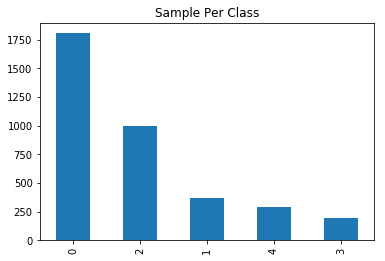

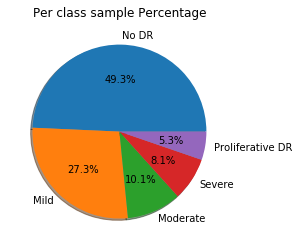

In [5]:
chat_data = df_train.diagnosis.value_counts()
chat_data.plot(kind='bar');
plt.title('Sample Per Class');
plt.show()
plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"])
plt.title('Per class sample Percentage');
plt.show()

Histogram is clearing showing that training data is Imbalanced. Because in class ‘No DR’ records are approx. 1750 while in class ‘Severe’ very less. So, may be for balancing data set, we would be requiring data augmentation. 

There are couple of ways to do image data augmentation. We will see down in this kernel.


<a id="4"></a>
### Train and Test dataset 
- We will use pie chart for showing the size of dataset.

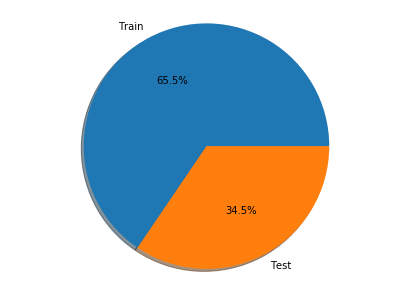

In [6]:
# Train & Test samples ratio
# Plot Data
labels = 'Train', 'Test'
sizes = df_train.shape[0], df_test.shape[0]
colors = 'lightskyblue', 'lightcoral'
# Plot
plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

It's showing train and testing data are in 2:1 ratio. Both are quite small data set.

<a id="6"></a>
#### Split DataSet

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2,
                                                    random_state=SEED, stratify=df_train.diagnosis)


Data visualization is a process in  AI, which will give you better insight of data.

In [8]:
def draw_img(imgs, target_dir, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(dir_path, f"{target_dir}/{row['id_code']}.png")
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis[row, col].imshow(img)
    plt.suptitle(class_label)
    plt.show()

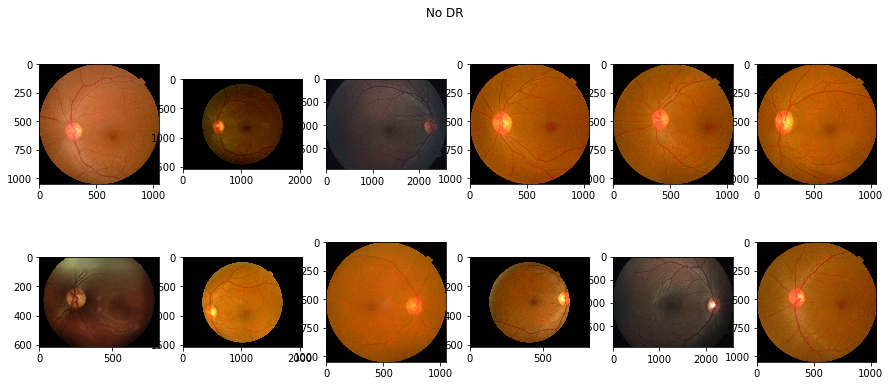

In [9]:
CLASS_ID = 0
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

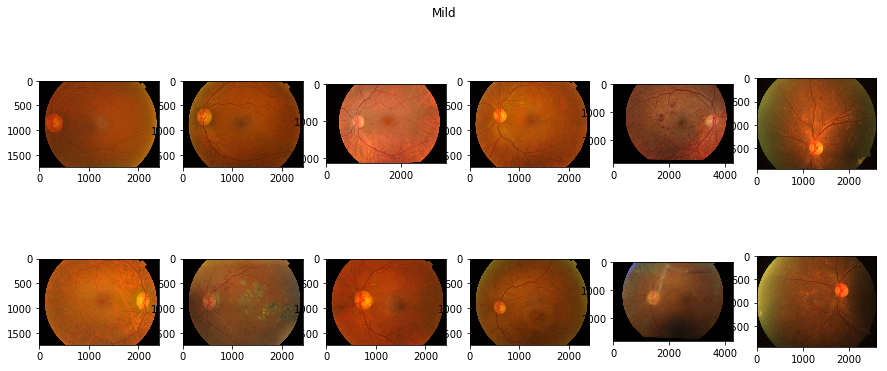

In [10]:
CLASS_ID = 1
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

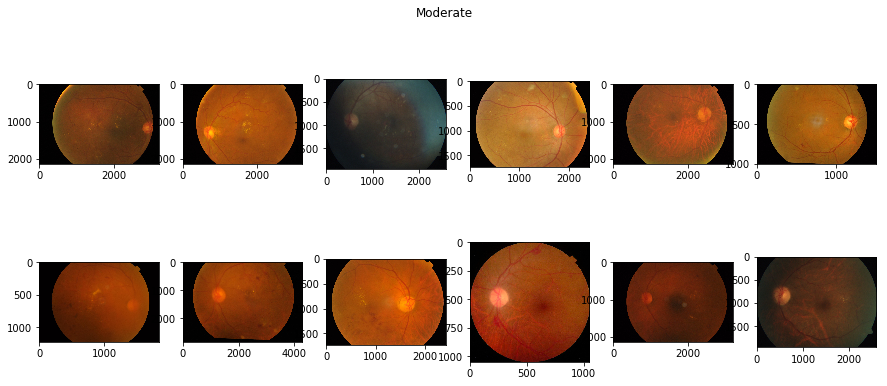

In [11]:
CLASS_ID = 2
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

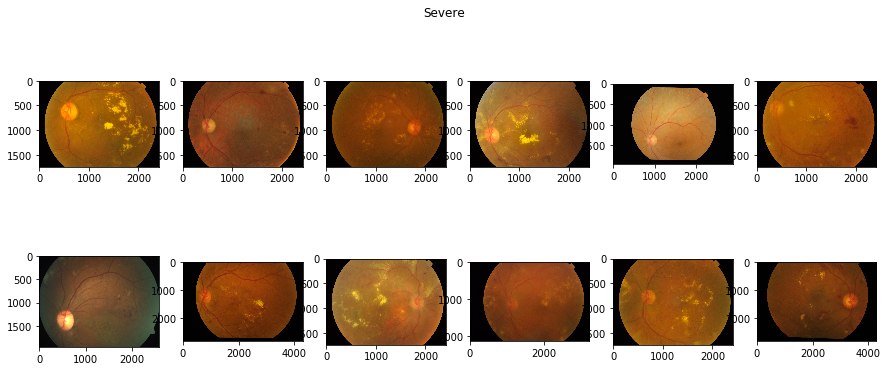

In [12]:
CLASS_ID = 3
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

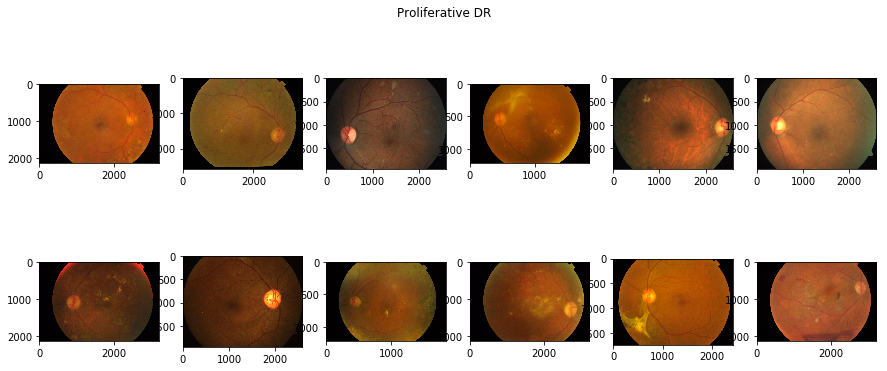

In [13]:
CLASS_ID = 4
draw_img(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

Sample images of dataset.
- As we can see the image shape is not in standard shape, we need to resize data set image.
- Some images are very small, and some are very large they are not in same standard.
- Some are having large black area like image Proliferative[1,2] has lot of black area. Which is not relevant for your problem? May we would be requiring doing the image cropping.
- Some image light is very dark.


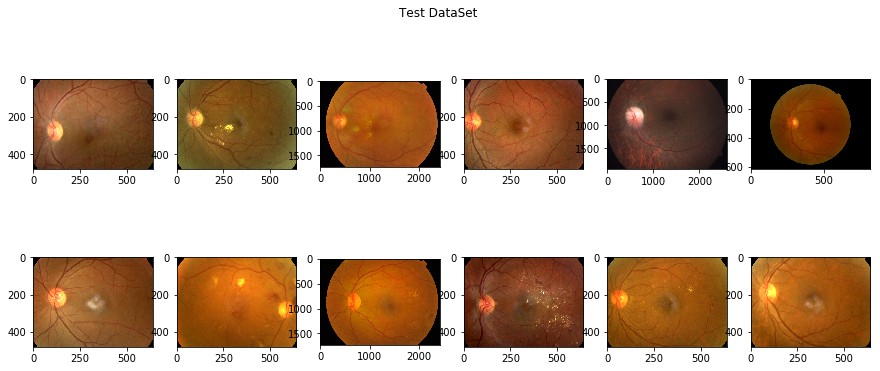

In [14]:
CLASS_ID = 'Test DataSet'
draw_img(df_test.sample(12, random_state=SEED), 'test_images', CLASS_ID)

- In Test data, there are some image are bigger and some are having black area. So, testing images also require doing image pre-processing.  
- May be would be require creating our image Generator.

<a id="6"></a>

### Max Min Height and Width

In [15]:
def check_max_min_img_height_width(df, img_dir):
    max_Height , max_Width =0 ,0
    min_Height , min_Width =sys.maxsize ,sys.maxsize 
    for idx, row in df.iterrows():
        imgPath=os.path.join(dir_path,f"{img_dir}/{row['id_code']}.png") 
        img=cv2.imread(imgPath)
        H,W=img.shape[:2]
        max_Height=max(H,max_Height)
        max_Width =max(W,max_Width)
        min_Height=min(H,min_Height)
        min_Width =min(W,min_Width)
    return max_Height, max_Width, min_Height, min_Width

In [16]:
check_max_min_img_height_width(df_train, TRAIN_DIR)

(2848, 4288, 358, 474)

In [17]:
check_max_min_img_height_width(df_test, TEST_DIR)

(1958, 2896, 480, 640)

<a id="7"></a>
### GrayScale Images
Converting the Ratina Images into Grayscale. So, we can usnderstand the regin or intest .

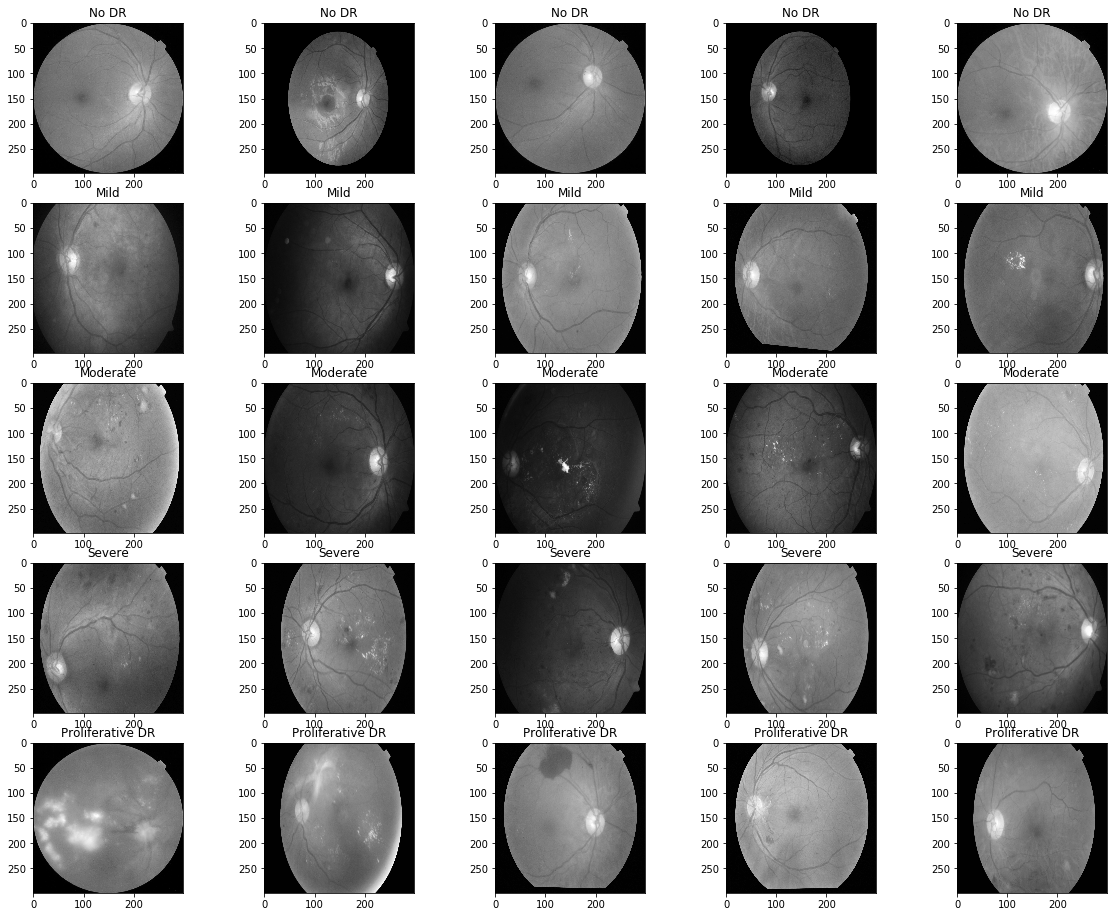

In [18]:
# Display some random images from Data Set with class categories ing gray
figure = plt.figure(figsize=(20, 16))
for target_class in (y_train.unique()):
    for i, (idx, row) in enumerate(
            df_train.loc[df_train.diagnosis == target_class].sample(5, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5, 5, target_class * 5 + i + 1)
        imagefile = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        img = cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        plt.imshow(img, cmap='gray')
        ax.set_title(CLASSS[target_class])


It's clearly showing, that the image [0,1] has give regin  black around the EYE ball. Which is ust noise, that will not add any value fo model. We need to remove this black area. in my next iteration will work on that to crop black are from image. 

## Image Cropping
Some images has big blank space. they will take only computation power and add noise to model.
So better will will crop the blank spaces from images. 

#### References
I have followed the below kaggle kernal for it. 

https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping


In [19]:
# Add Lighting to the images for improving the visibility 

def draw_img_light(imgs, target_dir, class_label='0'):
    fig, axis = plt.subplots(2, 6, figsize=(15, 6))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(dir_path, f"{target_dir}/{row['id_code']}.png")
        img = cv2.imread(imgPath)
        row = idnx // 6
        col = idnx % 6
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , IMG_DIM/10) ,-4 ,128) # the trick is to add this line
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        axis[row, col].imshow(img, cmap='gray')
    plt.suptitle(class_label)
    plt.show()

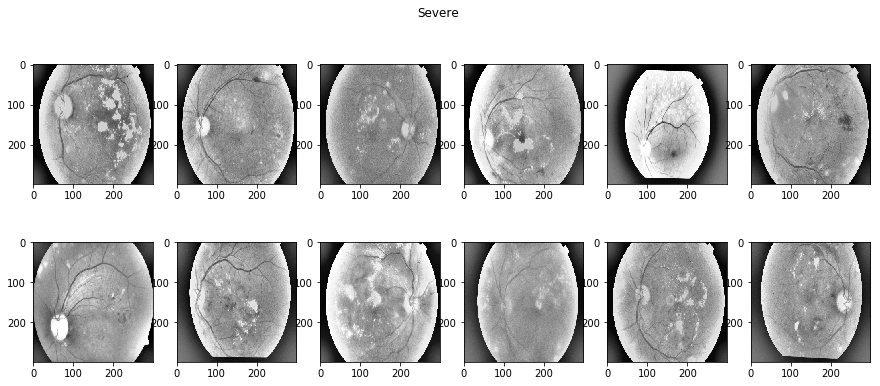

In [20]:
CLASS_ID = 3
draw_img_light(df_train[df_train.diagnosis == CLASS_ID].head(12), 'train_images', CLASSS[CLASS_ID])

In [21]:
# Image Croping
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


In [22]:
def crop_image_from_gray(img,tol=7):
    if img.ndim== 2:
        mask=img>tol
    elif img.ndim==3:
        gray_img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        mask=gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
#         check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if check_shape ==0: # Image was full dark and may be cropout everything.
            return img # Return original Image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            print(img1.shape,img2.shape,img3.shape)            
            img=np.stack([img1,img2,img3],axis=1)
            print(img.shape)
            return img

In [23]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)S
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_DIM, IMG_DIM))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

(1050, 1050) (1050, 1050) (1050, 1050)
(1050, 3, 1050)


error: OpenCV(4.1.0) /io/opencv/modules/imgproc/src/resize.cpp:3361: error: (-215:Assertion failed) !dsize.empty() in function 'resize'


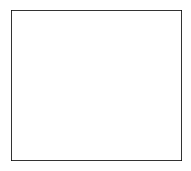

In [24]:
%%time

NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y_train.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

In [25]:
def crop_image(img,tol=7):
    w, h = img.shape[1],img.shape[0]
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = cv2.blur(gray_img,(5,5))
    shape = gray_img.shape 
    gray_img = gray_img.reshape(-1,1)
    quant = quantile_transform(gray_img, n_quantiles=256, random_state=0, copy=True)
    quant = (quant*256).astype(int)
    gray_img = quant.reshape(shape)
    xp = (gray_img.mean(axis=0)>tol)
    yp = (gray_img.mean(axis=1)>tol)
    x1, x2 = np.argmax(xp), w-np.argmax(np.flip(xp))
    y1, y2 = np.argmax(yp), h-np.argmax(np.flip(yp))
    if x1 >= x2 or y1 >= y2 : # something wrong with the crop
        return img # return original image
    else:
        img1=img[y1:y2,x1:x2,0]
        img2=img[y1:y2,x1:x2,1]
        img3=img[y1:y2,x1:x2,2]
        img = np.stack([img1,img2,img3],axis=-1)
    return img

def process_image(image, size=512):
    image = cv2.resize(image, (size,int(size*image.shape[0]/image.shape[1])))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    try:
        image = crop_image(image, tol=15)
    except Exception as e:
        image = image
        print( str(e) )
    return image

In [26]:
# # 178412895d5e
# process_image
# imagefile=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
# img=cv2.imread(imagefile)
# process_image(img, size=IMG_DIM)
# plt.imshow('Crop',process_image(img, size=IMG_DIM))

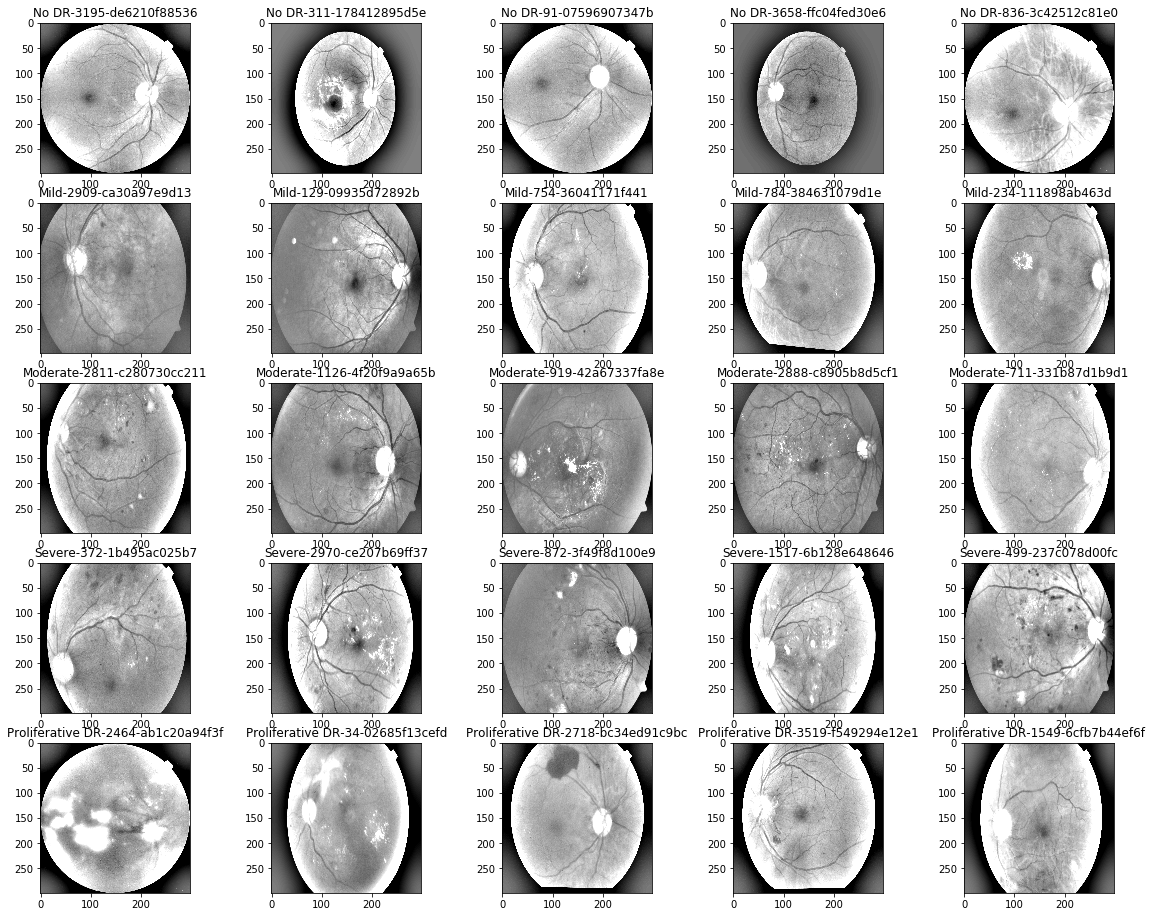

In [27]:
# Display some random images from Data Set with class categories. showig Gray image removing other channel and adding lighting to image.
figure = plt.figure(figsize=(20, 16))
for target_class in (y_train.unique()):
    #     print(CLASSS[target_class],target_class)
    for i, (idx, row) in enumerate(
            df_train.loc[df_train.diagnosis == target_class].sample(5, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5, 5, target_class * 5 + i + 1)
        imagefile = f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        img = cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMG_DIM, IMG_DIM))
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), IMG_DIM / 10), -4, 128)
        plt.imshow(img, cmap='gray')
        ax.set_title('%s-%d-%s' % (CLASSS[target_class], idx, row['id_code']))
#         print(row['id_code'])
#     plt.show()


<a id="8"></a>
# Data Pre-Processing

 #### Croping Images

https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv

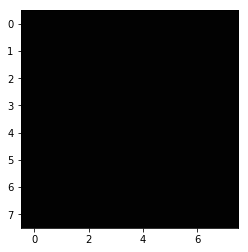

In [28]:
imgPath = f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
img = cv2.imread(imgPath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x, y, w, h = cv2.boundingRect(cnt)
img = img[y:y + h, x:x + w]
plt.imshow(img)


- Croping Images randomly for resizing.

In [29]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    img = img[y:(y + dy), x:(x + dx), :]
    return img


"""Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """


def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[0] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

            

- Adding image type with image in dataframe

In [30]:
# print("available RAM:", psutil.virtual_memory())
gc.collect()
# print("available RAM:", psutil.virtual_memory())

df_train.id_code = df_train.id_code.apply(lambda x: x + ".png")
df_test.id_code = df_test.id_code.apply(lambda x: x + ".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')


<a id="7"></a>
# Image Data Generator
In this section willl use Keras ImageDataGenerator class for generating data for Keras model. It is used for data generation, increasing the data size. with the help of ImageDataGenerator we will do image "augment" via a number of random transformations, so that our model would never see twice the exact same picture. 

Training Deep Learning model can perform better with more data, and augementation technique can create variations of data that can increase the ababiliy of fit model to gene



In [31]:
# Creating the imageDatagenerator Instance 
datagenerator=ImageDataGenerator(#rescale=1./255,
#                                       validation_split=0.15, 
                                         horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')

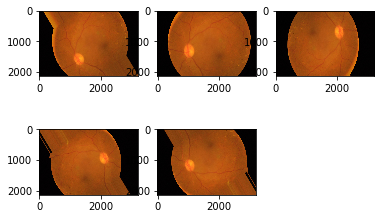

In [32]:
imgPath = f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
# Loading image
img = load_img(imgPath)
data = img_to_array(img)
samples =np.expand_dims(data, 0)
i=5
it=datagenerator.flow(samples , batch_size=1)
for i in range(5):
    plt.subplot(230 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [33]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                         validation_split=0.15, 
                                         horizontal_flip=True,
                                         vertical_flip=True, 
                                         rotation_range=40, 
                                         zoom_range=0.2, 
                                         shear_range=0.1,
                                        fill_mode='nearest')
# valid_datagen=image.ImageDataGenerator(rescale=1./255)

In [34]:
train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shaffle=True,
                                                    seed=SEED,
                                                    )
valid_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="../input/aptos2019-blindness-detection/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shaffle=True,
                                                    seed=SEED
                                                    )
del x_train
# # del x_test
del y_train
# del y_test
gc.collect()
#  color_mode= "grayscale",


Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


8191

<a id="8"></a>
# Model Architecture Design

In [35]:
def design_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(2, 2), input_shape=[IMG_DIM, IMG_DIM, CHANNEL_SIZE], activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation=relu))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(units=1000, activation=relu))
    model.add(Dropout(rate=0.2))
    model.add(Dense(5, activation='softmax'))
    return model


model = design_model()
# model.summary()


### Compile model

In [36]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

<a id="9"></a>
# Keras Callback Funcations
- Call Back functions Eraly Stoping and Learning Rate Reducing

In [37]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [38]:
NUB_TRAIN_STEPS = train_generator.n // train_generator.batch_size
NUB_VALID_STEPS = valid_generator.n // valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(259, 45)

In [39]:
# model.fit_generator(generator=train_generator,
#                     validation_data=valid_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_steps=STEP_SIZE_TRAIN,
#                     verbose=1,
#                     callbacks=[checkpoint],
#                     use_multiprocessing=True,
#                     workers=3,
#                     shuffle=True,
#                     max_queue_size=16,
#                     epochs=NB_EPOCHS)


<a id="10"></a>
# Transfer Learning 

In [40]:
def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50weightsfile/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(2048, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation=elu)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)

    return model_resnet


model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [41]:
# # Layers 
# for i, lay in enumerate(model_resnet.layers):
#     print(i,lay.name)
# Training All Layers

for layers in model_resnet.layers:
    layers.trainable = True


In [42]:
lr = 1e-3
optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) # Adam(lr=lr, decay=0.01) 
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# model.summary()
gc.collect()


373

In [43]:
history = model_resnet.fit_generator(generator=train_generator,
                                     steps_per_epoch=NUB_TRAIN_STEPS,
                                     validation_data=valid_generator,
                                     validation_steps=NUB_VALID_STEPS,
                                     epochs=NUM_EPOCHS,
                                     #                            shuffle=True,  
                                     callbacks=[eraly_stop, reduce_lr],
                                     verbose=2)
gc.collect()


Epoch 1/60
 - 447s - loss: 1.4381 - acc: 0.5801 - val_loss: 0.9325 - val_acc: 0.7037
Epoch 2/60
 - 421s - loss: 0.9645 - acc: 0.6808 - val_loss: 0.7497 - val_acc: 0.7281
Epoch 3/60
 - 425s - loss: 0.8486 - acc: 0.7044 - val_loss: 0.7531 - val_acc: 0.7430
Epoch 4/60
 - 421s - loss: 0.7416 - acc: 0.7325 - val_loss: 0.6741 - val_acc: 0.7505
Epoch 5/60
 - 420s - loss: 0.7035 - acc: 0.7441 - val_loss: 0.5725 - val_acc: 0.7821
Epoch 6/60
 - 420s - loss: 0.6809 - acc: 0.7523 - val_loss: 0.5818 - val_acc: 0.7747
Epoch 7/60
 - 421s - loss: 0.6330 - acc: 0.7740 - val_loss: 0.6194 - val_acc: 0.7952

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/60
 - 418s - loss: 0.5886 - acc: 0.7774 - val_loss: 0.5266 - val_acc: 0.7989
Epoch 9/60
 - 420s - loss: 0.5632 - acc: 0.7885 - val_loss: 0.4704 - val_acc: 0.8119
Epoch 10/60
 - 420s - loss: 0.5375 - acc: 0.8048 - val_loss: 0.5118 - val_acc: 0.8082
Epoch 11/60
 - 421s - loss: 0.5314 - acc: 0.8013 - val_loss: 0.5448

220

<a id="11"></a>
# Display Validation Accuracy & Loss


In [44]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

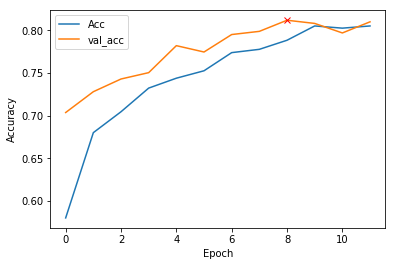

In [45]:
accu = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(accu, label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc', 'val_acc'])
plt.plot(np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()



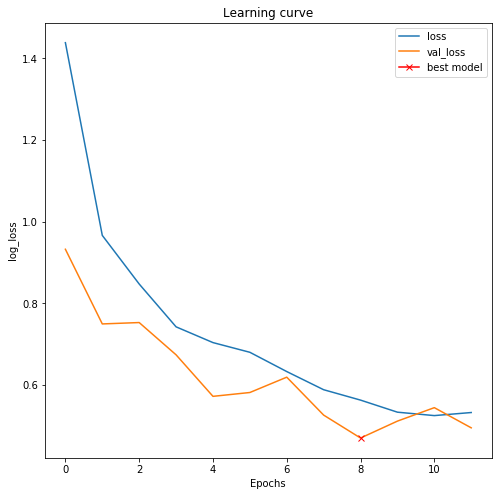

In [46]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


<a id="12"></a>
## Validation Accuracy

In [47]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy) = tqdm(
    model_resnet.evaluate_generator(generator=valid_generator, steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras_pre..., steps=45, use_multiprocessing=False)`
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 2/2 [00:00<00:00, 8594.89it/s]

[INFO] accuracy: 79.70%
[INFO] Loss: 0.5048952465616791


In [48]:
test_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2, horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory="../input/aptos2019-blindness-detection/test_images/",
                                                  x_col="id_code",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()


Found 1928 validated image filenames.
1928


5150

Kapkaha

<a id="13"></a>
# Test-Time Augmentation
In the below section, we are doning TTA imporving the prediction accuracy. It will transform image and predict 

In [49]:
tta_steps = 5
preds_tta = []
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator, steps=ceil(df_test.shape[0]))
    #     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))


100%|██████████| 5/5 [06:06<00:00, 73.31s/it]


In [50]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)


1928

In [51]:
# del valid_generator
# gc.collect()
# test_generator.reset()

# pred=model.predict_generator(test_generator, verbose=0, steps=STEP_SIZE_TEST)
# predicted_class_indices=np.argmax(pred,axis=1)

In [52]:
# test_generator.filenames.apply(lambda x: x[-4])
results = pd.DataFrame({"id_code": test_generator.filenames, "diagnosis": predicted_class_indices})
results.id_code = results.id_code.apply(lambda x: x[:-4])  # results.head()
results.to_csv("submission.csv", index=False)


  <a id="14"></a>
 # Visualization Test Result
- this section will visualize the predicted classes of test data.

Text(0.5, 1.0, 'Test Samples Per Class')

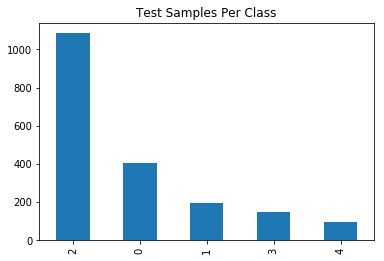

In [53]:
results['diagnosis'].value_counts().plot(kind='bar')
plt.title('Test Samples Per Class')


References:

1. https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
1. https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
1. https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/
1. https://jkjung-avt.github.io/keras-image-cropping/
1. https://www.kaggle.com/aleksandradeis/aptos2019-blindness-detection-eda